# **Loan Approval**  
By *Jorge López Díaz*

## **General Description**

The dataset used in this project contains **realistic information about loan applications** submitted in **the United States and Canada**.  
Each row represents an **individual loan request**, while the columns describe **personal, employment, and financial characteristics** of the applicant, as well as details related to the loan itself.

The dataset is designed for **credit risk analysis**, a common problem in the financial sector, and provides a sufficient number of observations and variables to apply **supervised machine learning techniques**.

---

## **Classification Problem Objective**

The main goal of this study is to develop and compare several **supervised classification models** in order to **predict whether a loan application will be approved**.

- **Problem type**: Binary classification  
- **Target variable**: `loan_status`  
- **Classes**:  
  - `1` → Loan approved  
  - `0` → Loan rejected  

Accurate predictions of this variable allow financial institutions to **improve decision-making**, reduce default risk, and optimize credit allocation.

---

## **Description of the Variables**

Below is a detailed description of the variables included in the dataset:

#### **Customer Identification**

- **`customer_id`**  
  Unique identifier for the applicant. This variable does not provide predictive value and will not be used as an explanatory feature in the models.

#### **Personal and Employment Variables**

- **`age`**  
  Applicant's age, expressed in years.

- **`occupation_status`**  
  Employment status of the applicant (e.g., employed, self-employed, unemployed, etc.).

- **`years_employed`**  
  Number of years the applicant has been employed.

- **`annual_income`**  
  Applicant's annual income.

#### **Credit History and Credit Behavior Variables**

- **`credit_score`**  
  Applicant’s credit score — a key indicator of financial reliability.

- **`credit_history_years`**  
  Length of the applicant’s credit history, measured in years.

- **`defaults_on_file`**  
  Indicates whether the applicant has any recorded defaults in their credit history.

- **`delinquencies_last_2yrs`**  
  Number of payment delinquencies or late payments in the past two years.

- **`derogatory_marks`**  
  Number of significant negative remarks or flags in the applicant's credit history.

#### **Current Financial Variables**

- **`savings_assets`**  
  Estimated value of the applicant’s savings or financial assets.

- **`current_debt`**  
  Applicant’s total current debt.

- **`debt_to_income_ratio`**  
  Ratio between the applicant’s total debt and their annual income.

#### **Loan-Related Variables**

- **`product_type`**  
  Type of financial product requested.

- **`loan_intent`**  
  Purpose of the loan (personal, education, business, etc.).

- **`loan_amount`**  
  Amount of money requested by the applicant.

- **`interest_rate`**  
  Interest rate applied to the loan.

- **`loan_to_income_ratio`**  
  Ratio between the loan amount and the applicant’s annual income.

- **`payment_to_income_ratio`**  
  Percentage of the applicant’s income allocated to periodic loan payments.

#### **Target Variable**

- **`loan_status`**  
  Binary variable indicating whether the loan application was **approved (`1`)** or **rejected (`0`)**.

---

# **PHASE I** 
**Importing libraries, loading the data, and performing EDA**

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
import json
import shap 
from sklearn.inspection import permutation_importance



### **Loading data**
To accelerate experiments we have carried out subsampling.  
The number of samples can be modified as desired bearing in mind the dataset contains 50K rows.


In [24]:
df = pd.read_csv('Loan_approval_data_2025.csv')

# Max number of samples - to speed up experiments
n_samples = 5000

# Percentaje of each class
class_counts = df['loan_status'].value_counts(normalize=True)

# Number of samples per class
n_per_class = (class_counts * n_samples).round().astype(int)

# Stratified subsampling
df_subsampled = (
    df.groupby('loan_status', group_keys=False)
      .apply(lambda x: x.sample(n=n_per_class.loc[x.name], random_state=42))
)

# Mixing rows
df_subsampled = df_subsampled.sample(frac=1, random_state=42).reset_index(drop=True)

df_subsampled.shape

C:\Users\jlope\AppData\Local\Temp\ipykernel_25652\4252529883.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=n_per_class.loc[x.name], random_state=42))


(5000, 20)

In [25]:
initial_df = df_subsampled
initial_df.head()

,customer_id,age,occupation_status,years_employed,annual_income,credit_score,credit_history_years,savings_assets,current_debt,defaults_on_file,delinquencies_last_2yrs,derogatory_marks,product_type,loan_intent,loan_amount,interest_rate,debt_to_income_ratio,loan_to_income_ratio,payment_to_income_ratio,loan_status
0,CUST118635,28,Employed,7.5,19938,489,4.5,214,5912,0,0,0,Line of Credit,Personal,8600,14.37,0.297,0.431,0.144,0
1,CUST105107,35,Student,1.5,26624,765,16.5,11559,10513,0,1,0,Credit Card,Education,2700,15.17,0.395,0.101,0.034,1
2,CUST117189,45,Student,0.3,31247,696,25.0,738,6111,0,0,0,Credit Card,Personal,3100,17.13,0.196,0.099,0.033,1
3,CUST132555,26,Employed,7.1,18787,494,5.8,68,6929,0,2,0,Line of Credit,Medical,6900,14.73,0.369,0.367,0.122,0
4,CUST114778,33,Self-Employed,6.2,106733,719,14.3,2412,59309,0,0,0,Personal Loan,Personal,6100,10.79,0.556,0.057,0.019,0


#### Droping unnecessary columns

In [26]:
df = initial_df.drop(columns=['customer_id'])  # Dropping ID column

#### Dealing with nulls

In [27]:
df.isnull().sum()

age                        0
occupation_status          0
years_employed             0
annual_income              0
credit_score               0
credit_history_years       0
savings_assets             0
current_debt               0
defaults_on_file           0
delinquencies_last_2yrs    0
derogatory_marks           0
product_type               0
loan_intent                0
loan_amount                0
interest_rate              0
debt_to_income_ratio       0
loan_to_income_ratio       0
payment_to_income_ratio    0
loan_status                0
dtype: int64

No nulls found

### **Distribution of all numeric variables**

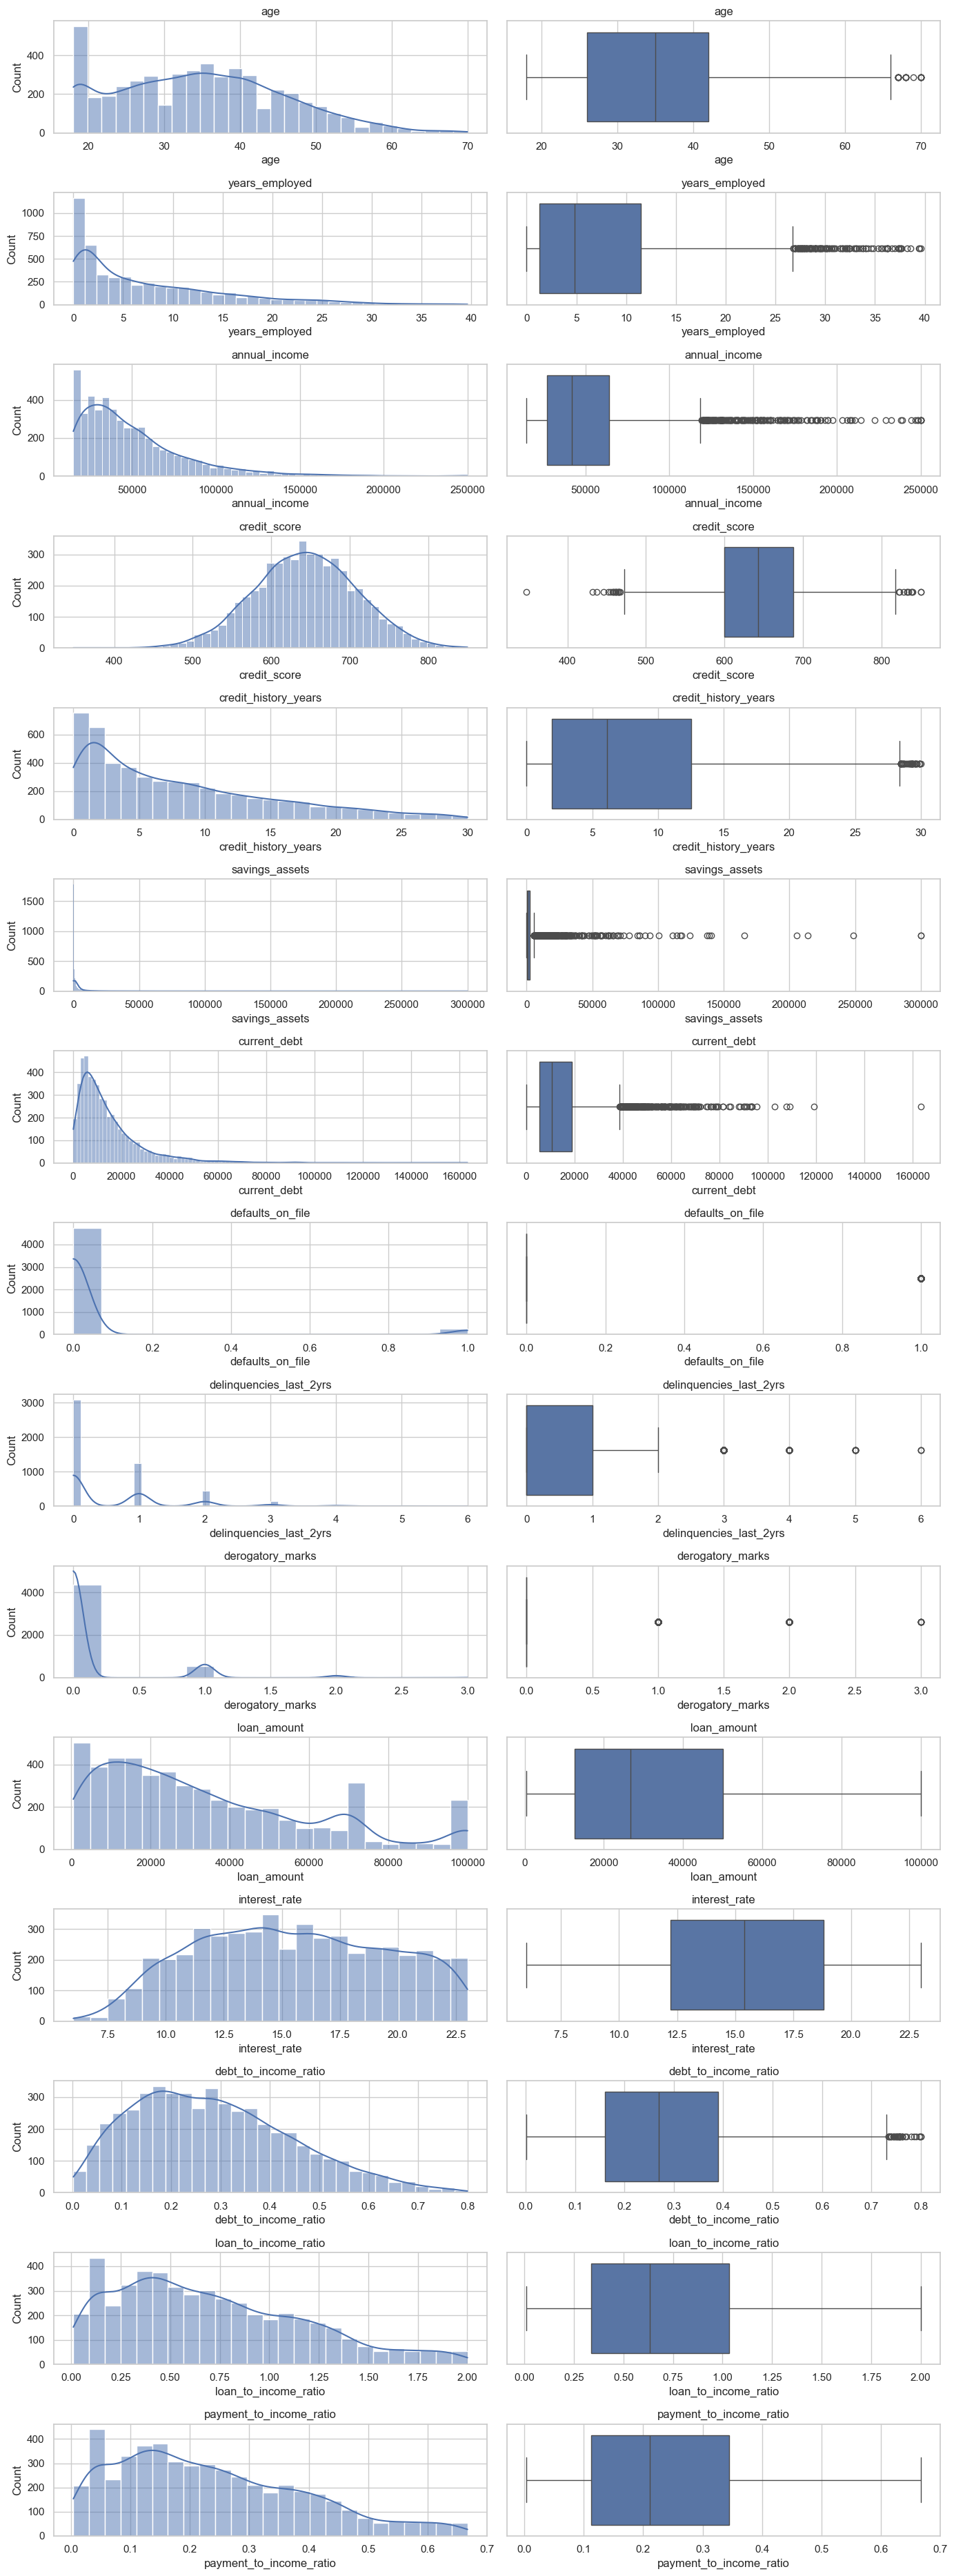

In [28]:

# numeric columns 
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_cols.remove('loan_status')  # Exclude target variable 

# categoric columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Figure config: one row (hist + box) for each numeric variable
n = len(num_cols)
plt.figure(figsize=(14, n * 2.5))

for i, col in enumerate(num_cols):
    
    # Histogram
    plt.subplot(n, 2, 2*i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'{col}')
    
    # Boxplot
    plt.subplot(n, 2, 2*i + 2)
    sns.boxplot(x=df[col])
    plt.title(f'{col}')

plt.tight_layout() 

### **Categorical variables in relation to loan status**

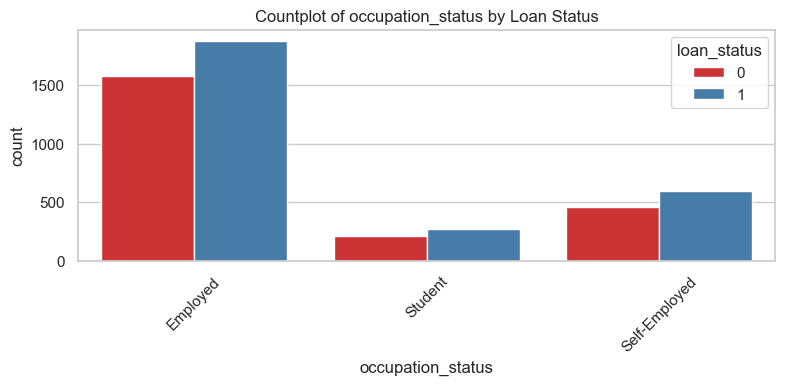

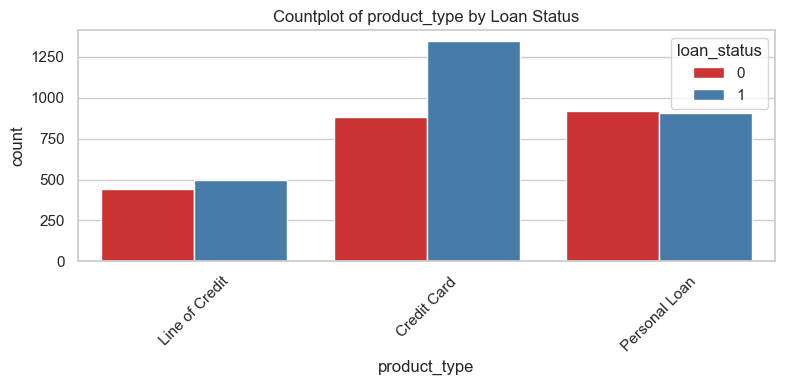

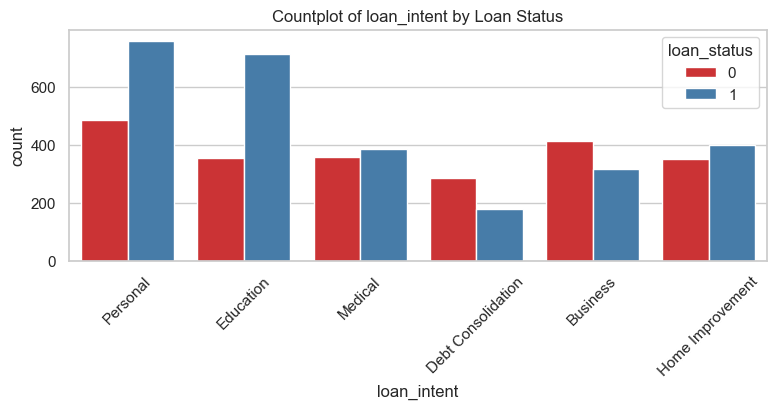

In [29]:
for col in cat_cols:
    plt.figure(figsize=(9, 3))
    sns.countplot(data=df, x=col, hue='loan_status', palette='Set1')
    plt.title(f'Countplot of {col} by Loan Status')
    plt.xticks(rotation=45)

### **Correlations**  
Goal is to keep variables unless correlation between them is over a threshold.
- Heatmap 
- Function - ``highly_correlated_features`` 

<Axes: >

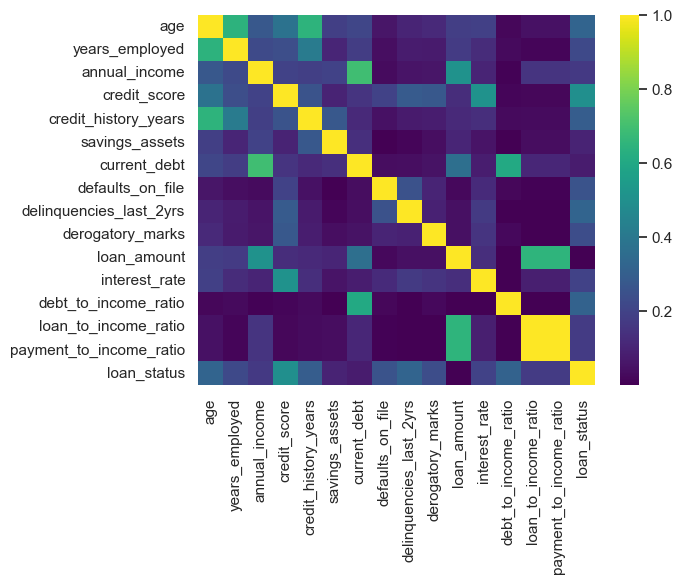

In [30]:
# Correlation heatmap
corr = df.select_dtypes(include=['int64', 'float64']).corr().abs() 
sns.heatmap(corr, cmap="viridis")

In [31]:
def highly_correlated_features(df, threshold=0.7):
    """
    Returns pairs of features with absolute correlation above threshold
    """
    corr_matrix = df.corr().abs()

    # Upper triangle of correlation matrix to avoid duplicates
    upper = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )

    # Extract high correlations
    high_corr = (
        upper
        .stack()
        .reset_index()
    )
    high_corr.columns = ["feature_1", "feature_2", "abs_correlation"]

    return high_corr[high_corr["abs_correlation"] > threshold].sort_values(
        "abs_correlation", ascending=False
    )
highly_correlated_features(df.select_dtypes(include=['int64', 'float64']))

,feature_1,feature_2,abs_correlation
117,loan_to_income_ratio,payment_to_income_ratio,0.999999


- This correlation is kind of obvious given LTI is a linear transformation of PTI. This is a concern to linear models such as SVM linear, KNN or logistic regression. Therefore, we will eliminate LTI as PTI is more informative to predict loan approvals.

In [32]:
df = df.drop(columns= ['loan_to_income_ratio'])

# **PHASE II** 
### **Preprocessing**

In [33]:
# ----- SPLITTING DATA INTO TRAIN AND TEST SETS -----

X = df.drop(columns=['loan_status'])
y = df['loan_status']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2, 
    random_state=42,
    stratify=y # Ensures original proportion on classes in loan_status
)

#----- PREPROCESSING ------

# Columns that requires log transform + std
high_skewness = ["annual_income", "savings_assets"]

# Columns that requires only std
std_only = ["age", "credit_score", "loan_amount", "interest_rate", "debt_to_income_ratio",
             "payment_to_income_ratio", "years_employed","current_debt","credit_history_years"]

# Columns that requires no prior transform
no_prior_transform = ["defaults_on_file", "delinquencies_last_2yrs", "derogatory_marks"]

# Log1p transformer
log1p_transformer = FunctionTransformer(func=np.log1p, validate=True, 
                                        feature_names_out="one-to-one") # to keep feature names

# Preprocessor definition
preprocessor = ColumnTransformer(
    transformers=[
        # log1p + standarization
        ("log", 
         Pipeline([
             ("log", log1p_transformer),
             ("std", StandardScaler())
         ]), 
         high_skewness),

        # Standarization only
        ("std", 
         StandardScaler(), 
         std_only),

        # OneHotEncoder for categoric variables
         ('ohe', 
        OneHotEncoder(sparse_output=False, # True if high amount of data
                      drop='first'), # to avoid dummy variable trap
        cat_cols   
         ),

        # No prior transform
        ("-", 
         "passthrough", 
         no_prior_transform)
    ],
    remainder="drop"
)

# --- ACLARATION ---
# TO avoid data leakage, preprocessing is done internally in grid search and cross-validation using a Pipeline
# Therfore, the following code is just to see how it works in our data.
# Fitting preprocessor on training data
preprocessor.fit(X_train)
# Transforming both training and test data
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)


#### **Preprocessing Summary**

- **Stratified Train-Test Split**: Splits data (80/20) ensuring the proportion of the target class (``loan_status``) remains consistent in both sets, which is crucial for imbalanced classification problems.

- **Log1p + StandardScaler**: Applies a log transformation to highly skewed features (``annual_income``, ``savings_assets``) to normalize their distribution (handling zeros with ``1p``), followed by scaling to align magnitudes.

- **StandardScaler (std only)**: Standardizes continuous variables (e.g., ``age``, ``interest_rate``) to a mean of 0 and variance of 1, preventing features with large raw values from dominating the model's objective function.

- **Passthrough**: Retains specific count-based features (``defaults_on_file``, ``delinquencies``) in their original form, as they are low-magnitude integers where scaling provides minimal benefit.

- **OneHotEncoder**: Converts categorical variables into binary dummy variables, dropping the first category (``drop='first'``) to prevent multicollinearity (dummy variable trap).

- **Data Leakage Prevention**: Explicitly fits the preprocessor only on ``X_train`` and then transforms ``X_test``, ensuring the model does not "peek" at test data statistics during training.

### **Preprocessing evaluation**

In [34]:
# Showing transformed training data 
feature_names = preprocessor.get_feature_names_out()
X_train_transformed_df = pd.DataFrame(
    X_train_transformed,
    columns=feature_names
)
X_train_transformed_df.head()


,log__annual_income,log__savings_assets,std__age,std__credit_score,std__loan_amount,std__interest_rate,std__debt_to_income_ratio,std__payment_to_income_ratio,std__years_employed,std__current_debt,...,ohe__product_type_Line of Credit,ohe__product_type_Personal Loan,ohe__loan_intent_Debt Consolidation,ohe__loan_intent_Education,ohe__loan_intent_Home Improvement,ohe__loan_intent_Medical,ohe__loan_intent_Personal,-__defaults_on_file,-__delinquencies_last_2yrs,-__derogatory_marks
0,0.197827,-0.251374,0.739884,-0.029804,0.625441,1.113502,0.164085,0.721850,1.029652,0.024834,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-1.387506,0.708219,-0.345487,-1.637462,-0.456452,1.714563,1.788252,0.968739,0.138913,-0.285720,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,-0.166404,-0.383777,-0.616830,-0.217104,0.606527,1.312200,-0.906248,1.234619,-0.581538,-0.668339,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,-1.742981,-0.115731,-0.616830,-0.466837,-0.172739,-0.312156,0.568571,2.608335,-0.227862,-0.648824,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0
4,-0.860354,-0.126342,2.096599,1.702720,-1.182758,-0.364315,0.861045,-1.291245,-0.751826,-0.275561,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
# Showing transformed test data 
feature_names = preprocessor.get_feature_names_out()
X_test_transformed_df = pd.DataFrame(
    X_test_transformed,
    columns=feature_names
)
X_test_transformed_df.head()

,log__annual_income,log__savings_assets,std__age,std__credit_score,std__loan_amount,std__interest_rate,std__debt_to_income_ratio,std__payment_to_income_ratio,std__years_employed,std__current_debt,...,ohe__product_type_Line of Credit,ohe__product_type_Personal Loan,ohe__loan_intent_Debt Consolidation,ohe__loan_intent_Education,ohe__loan_intent_Home Improvement,ohe__loan_intent_Medical,ohe__loan_intent_Personal,-__defaults_on_file,-__delinquencies_last_2yrs,-__derogatory_marks
0,-0.078667,-0.912026,-0.435935,0.781829,-0.607766,0.512440,1.277977,-0.575900,0.269904,0.391447,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-0.372601,0.125610,-1.249964,-0.607312,-0.195436,1.277428,-1.522312,0.278716,-0.895916,-0.961424,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-0.057238,-0.695538,0.920780,-0.061021,-1.023879,-0.928120,-0.501762,-1.158305,2.234769,-0.448634,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1.547394,0.727229,1.282570,-0.310754,2.505515,-0.495952,1.352652,0.474961,2.260968,2.863305,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.180079,1.902339,-0.345487,1.343729,-0.653160,-1.377674,1.726024,-0.765815,-0.070673,0.882968,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 1.0, 'After log1p + std')

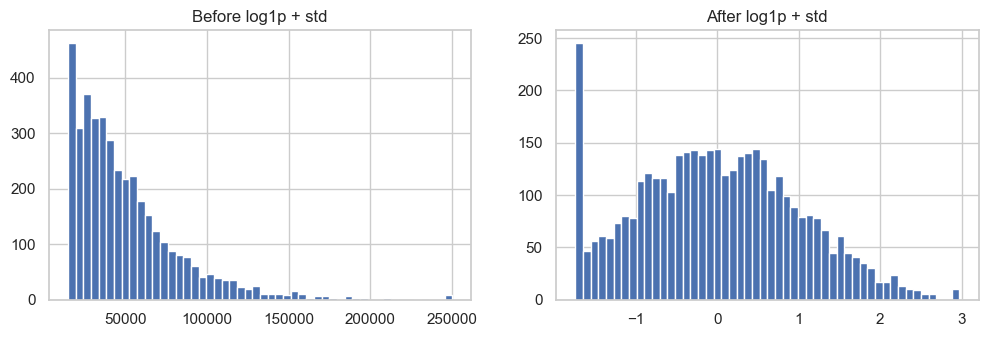

In [36]:
# Visualizing effect of log1p + std on "annual_income" (example)

plt.figure(figsize=(12, 3.5))

# Before
plt.subplot(1, 2, 1)
plt.hist(X_train["annual_income"], bins=50)
plt.title("Before log1p + std")

# After
plt.subplot(1, 2, 2)
plt.hist(
    X_train_transformed_df.filter(like="annual_income").iloc[:, 0],
    bins=50
)
plt.title("After log1p + std")


# **PHASE III**
**Training models, predictions and evaluation of each model**  
- KNN
- Logistic and Ridge Regression
- SVM (Linear and non-linear)
- Decision Trees


### **Functions to evaluate models**

1. `evaluate_all_metrics()` 
    - Extracts the raw scores for every cross-validation fold corresponding to the best model found by `GridSearchCV`. Instead of just looking at the mean score, this allows us to analyze the stability of the model (standard deviation) and check for overfitting in specific data splits.
2. ``print_metrics()``
    - Calculates standard classification metrics and plots a Confusion Matrix heatmap
3. ``visualize_cross_val_metrics()``
    - Generates a combined Violin and Swarm plot for the cross-validation scores.
4. ``plot_decision_tree()``
    - Extracts the underlying tree from the Pipeline, retrieves the transformed feature names, and plots the decision logic.

In [37]:
def evaluate_all_metrics(grid_search, print_dict=False):
    """
    Extract all metrics used in param scoring of grid_search from best model
    """

    # métricas que usaste en scoring del grid search
    metrics = list(grid_search.scoring.keys())
    results = grid_search.cv_results_
    best_idx = grid_search.best_index_ # pick results obtained when 

    output = {}

    for metric in metrics:
        scores = []

        # Identificar todos los splits disponibles
        split_keys = [k for k in results.keys() if k.startswith("split") and k.endswith(f"test_{metric}")]

        # Ordenar por número split0, split1, split2, ...
        split_keys = sorted(split_keys, key=lambda x: int(x.split("_")[0].replace("split", "")))

        # Extraer los valores del best_index para cada split
        for key in split_keys:
            scores.append(results[key][best_idx])

        # Guardar igual que en evaluate_all_metrics
        output[metric] = {
            "scores": scores,
            "mean": float(np.mean(scores)),
            "std": float(np.std(scores))
        }
        
    if print_dict:
        print("\n===== Cross-validation Metrics Summary =====\n")
        print(json.dumps(output, indent=4))
        print("\n=================================================================\n")

    return output

def print_metrics(y_true, y_pred, dataset_name):
    print(f"------------------ {dataset_name} RESULTS ------------------")
    print(f"Accuracy : {metrics.accuracy_score(y_true, y_pred):.3f}")
    print(f"Macro-Precision: {metrics.precision_score(y_true, y_pred, average='macro'):.3f}")
    print(f"Macro-Recall   : {metrics.recall_score(y_true, y_pred, average='macro'):.3f}")
    print(f"Macro-F1-score : {metrics.f1_score(y_true, y_pred, average='macro'):.3f}")

    cm = metrics.confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.ylabel('Truth')
    plt.xlabel('Prediction')
    plt.show()

    print("\nClassification Report:")
    print(metrics.classification_report(y_true, y_pred))
    return ""

def visualize_cross_val_metrics(metrics_dict, as_df=False):
    """
    Visualizes cross-validation metrics from the provided dictionary.
    If as_df=True, returns the DataFrame instead of plotting graphs.
    """

    # Convert metrics_dict to df
    df_vis = pd.DataFrame({metric: data['scores'] for metric, data in metrics_dict.items()})

    # returns directly df if as_df=True
    if as_df:
        return df_vis

    # Otherwise, produce the plot
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))

    # violin + swarm plot 
    sns.violinplot(data=df_vis, inner=None, palette="pastel", orient='h')
    sns.swarmplot(data=df_vis, color="k", alpha=0.6, size=4, orient='h')

    # mean points
    means = df_vis.mean()
    for i, mean in enumerate(means):
        plt.scatter(mean, i, color='red', s=100, marker='D', label='Mean' if i == 0 else "")

    plt.title("Cross-validation scores per metric", fontsize=16)
    plt.xlabel("Score", fontsize=12)
    plt.legend()

def plot_decision_tree(final_model, fig_size_x=20, fig_size_y=10, max_depth=None):
    """
    Graphs a decision tree coming from a Pipeline with preprocessor + dt (best_estimator_)
    """

    # Extract the DecisionTreeClassifier from the pipeline
    model = final_model.named_steps['dt']
    preprocessor = final_model.named_steps['preprocessor']

    # Names of the transformed features
    feature_names = preprocessor.get_feature_names_out()
    class_names = ['0', '1']

    fig, ax = plt.subplots(figsize=(fig_size_x, fig_size_y), dpi=300)

    print("Depth of the tree:", model.get_depth())
    print("Number of terminal nodes:", model.get_n_leaves())

    plot_tree(
        model,
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
        impurity=False,
        fontsize=10,
        precision=2,
        max_depth=max_depth,
        ax=ax
    )

    plt.tight_layout()

### **How to extract metrics efficiently:**

- During hyperparameter tuning, GridSearchCV performs cross-validation internally and stores all per-split scores for every metric in ``cv_results_``.
Because these scores already correspond to the best model selected according to the refitting criterion, using sci-kit learn `cross_validate` function afterward would unnecessarily retrain the model and recompute the metrics on different fits.

- Therefore, we extract the cross-validation metrics directly from the ``GridSearchCV`` object, ensuring methodological consistency between model selection and evaluation while avoiding redundant computation.

In [38]:
# To be used in grid_search
scoring = {
    'accuracy': metrics.make_scorer(metrics.accuracy_score),
    'precision': metrics.make_scorer(metrics.precision_score, average='macro'),
    'recall': metrics.make_scorer(metrics.recall_score, average='macro'),
    'f1': metrics.make_scorer(metrics.f1_score, average='macro'),
    'F0.7':metrics.make_scorer(metrics.fbeta_score, beta=0.7, average='macro') # giving double importance to precision (evaluate FP)
}

**``F0.7 (F-Beta with Beta=0.7)``**:
- This custom metric prioritizes Precision over Recall (Beta < 1).

- In lending, a False Positive (Predicting *Good Payer* when actually *Defaulter*) is the most costly error, as it leads to direct financial loss (defaulted principal).

- A False Negative (Rejecting a *Good Payer*) only results in lost potential interest (opportunity cost).

- Therefore, we **weight Precision higher** (two times over Recall) to enforce a **conservative approval strategy** that minimizes risk of default.

**``Average='macro'``**:
- Used to treat both classes (Approved or NonApproved) as equally important, regardless of class imbalance.

- Ensures the model doesn't just optimize for the positive class.

##  **KNN (K Nearest Neighbours)**

Best score      : 0.8438746496083622
Best params     : {'knn__metric': 'euclidean', 'knn__n_neighbors': 23, 'knn__weights': 'uniform'}


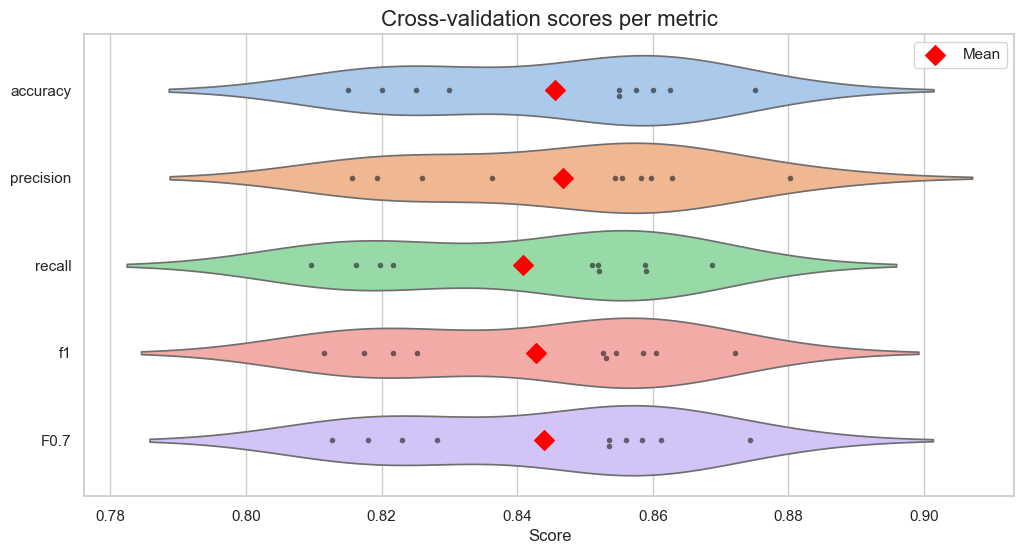

In [39]:
# parameter grid for KNN
param_grid = {
    'knn__n_neighbors': range(1, 31),
    'knn__metric': ['euclidean'],
    'knn__weights': ['uniform']
}

# Pipeline including preprocessor and KNN: 
# Crucial to avoid data leakage during cross-validation
pipe_knn = imbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE()), # no balance param in knn, then SMOTE to balance classes
    ('knn', neighbors.KNeighborsClassifier())
])

# Cross-validation stratified
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Grid search with cross-validation
grid_search = GridSearchCV(
    pipe_knn,
    param_grid,
    cv=cv,
    scoring= scoring,
    refit= 'F0.7', # metric to optimize
    n_jobs=-1 # Use all available cores
)

# Fitting grid search on training data
grid_search.fit(X_train, y_train)

#---- BEST PARAMETERS ----
print("Best score      :", grid_search.best_score_)
print("Best params     :", grid_search.best_params_)

# Use the trained pipeline directly
best_knn_model = grid_search.best_estimator_

#---- VALIDATION SCORES ----
scores = evaluate_all_metrics(grid_search)
visualize_cross_val_metrics(scores)


### **Key Decisions in Model Architecture**
- **Optimization Metric (``refit='F0.7'``)**
    * We prioritized ``F0.7`` over standard Accuracy or F1-score. As established, minimizing False Positives (bad loans) is financially more critical than avoiding False Negatives. By setting beta=0.7, we explicitly instruct the ``GridSearch`` to select the model that maximizes Precision (risk safety) while maintaining acceptable Recall.

- **Pipeline Construction & Leakage Prevention**

    * The preprocessor is placed inside the imbPipeline. This is mandatory to prevent Data Leakage. It ensures that scaling (StandardScaler) and encoding are fitted independently on each cross-validation training fold, without "seeing" the validation fold statistics.

- **Handling Imbalance with ``SMOTE``**

    * Unlike other models, ``KNN`` does not have a native ``class_weight`` parameter to handle imbalance.
    * We included ``SMOTE`` (Synthetic Minority Over-sampling Technique) in the pipeline to synthetically generate examples of the minority class (Defaults) in the training folds. This prevents the KNN from being biased toward the majority class simply due to density.

- **Hyperparameter Search Space**
    * We focused the grid on ``n_neighbors (1 to 30)``, which controls the model's complexity (bias-variance tradeoff). A focused search allows us to determine the optimal neighborhood size without unnecessary computational cost on less impactful parameters.

## **Linear SVM (Suported Vector Machine)**

Best params:  {'svm__C': 1, 'svm__class_weight': 'balanced', 'svm__dual': False, 'svm__loss': 'squared_hinge', 'svm__max_iter': 5000, 'svm__penalty': 'l2'}
Best score :  0.8594705179377471


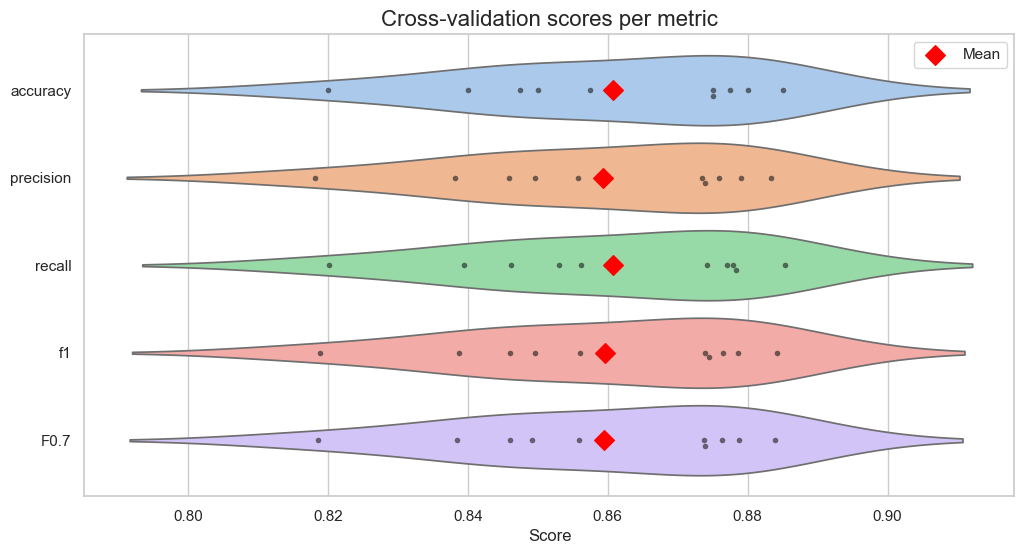

In [40]:

# SVM Linear hyperparameter grid
param_grid = {
    'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'svm__loss': ['squared_hinge'], # 'hinge' not supported with 'dual'='False'
    'svm__penalty': ['l2', 'l1'],
    'svm__dual': [False], # Setting dual to False as n_samples > n_features
    'svm__max_iter': [5000, 7000],
    'svm__class_weight' : ['balanced'] 

}
# Pipeline including preprocessor and SVM linear: 
# Crucial to avoid data leakage during cross-validation
pipe_linear_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svm', LinearSVC())
])
# Cross-validation stratified
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Hyperparameter tuning with GridSearchCV
grid = GridSearchCV(
    pipe_linear_svm, 
    param_grid, 
    cv=cv, 
    scoring=scoring,
    refit= 'F0.7', # metric to optimize 
    n_jobs=-1
)

grid.fit(X_train, y_train)

# Printing best parameters and best score
print("Best params: ", grid.best_params_)
print("Best score : ", grid.best_score_)

# final SVM linear model with best hyperparameters (already trained)
svm_final = grid.best_estimator_

# Just the model
svm = svm_final.named_steps['svm']

# To plot feature importance
explainer_log = shap.LinearExplainer(svm, X_train_transformed_df)
shap_values_svm = explainer_log(X_test_transformed_df)

scores_linear_svm = evaluate_all_metrics(grid)
visualize_cross_val_metrics(scores_linear_svm)


### **Key Decisions in Model Architecture (SVM)**
- **Handling Imbalance: Weights vs. SMOTEApproach**: Unlike the KNN pipeline where we used SMOTE to generate synthetic data, here we use ``class_weight='balanced'``. SVM allows us to modify the loss function directly by assigning a higher penalty to misclassifying the minority class. This is computationally more efficient and less prone to noise than oversampling.

- **Hyperparameter Grid** (``param_grid``)
    1. **``C`` (Regularization)**: Controls the trade-off between a smooth decision boundary and classifying training points correctly. Smaller ``C`` returns a simpler model (ensuring less overfitting), while larger ``C`` sets up a stricter model.

    2. **``dual=False``**: Explicitly set because *n_samples than n_features* in our dataset. This makes the primary optimization problem faster to solve than the dual problem.
    
    3. **``L1 / L2`` (Penalty)**: We test ``L1`` (Lasso) to potentially zero out irrelevant features and L2 (Ridge) for standard coefficient shrinkage.

- **Stratified CV**: To ensure that every fold in the cross-validation process preserves the original class proportion, which is critical for the ``class_weight`` parameter to calculate the inverse frequencies correctly.

### **Metrics and results**

### Plot of **feature importance** of linear SVM best model

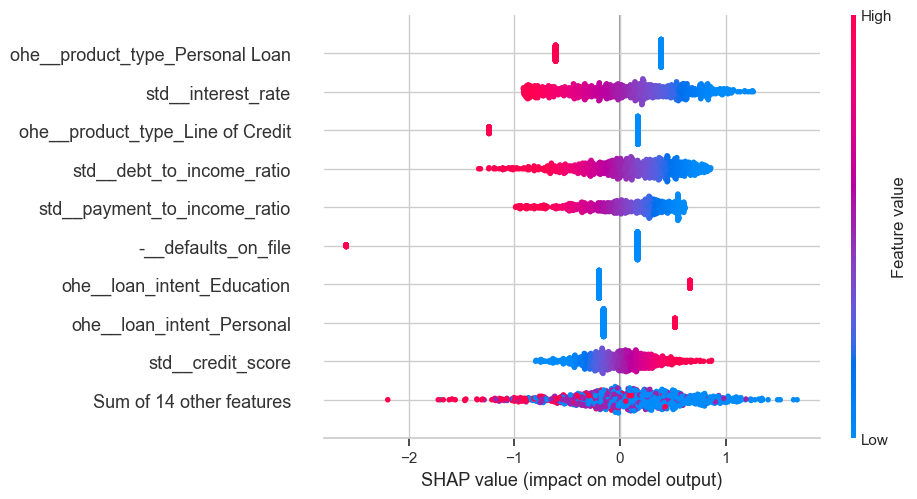

In [41]:
shap.plots.beeswarm(shap_values_svm)

- **Push to Reject**:

    * **``product_type_Personal Loan``**: The strongest negative signal. Simply requesting this loan type drastically increases rejection probability.

    * **``interest_rate``**: Higher rates (Red dots) align with higher risk, pushing predictions toward default.

    * **High Debt Ratios** (``debt_to_income``, ``payment_to_income``): As expected, over-leveraged applicants are heavily penalized.

    * **``defaults_on_file``**: clients with defaults on their credit history are enormously penalized.

- **Push to Approve**:

    * **``loan_intent_Education``**: Borrowing for education is a strong indicator of a safe loan.

    * **``credit_score``**: High scores (red dots) consistently push the model toward approval.

## **Non-linear SVM** *
Although linear SVM is also available in the SVC object, it was decided to evaluate them separately so as to allow a comparison between the linear and non-linear versions. In addition, LinearSVC is more efficient for large datasets.


Best params:  {'svm__C': 10, 'svm__class_weight': 'balanced', 'svm__degree': 2, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
Best score :  0.8944833058720979


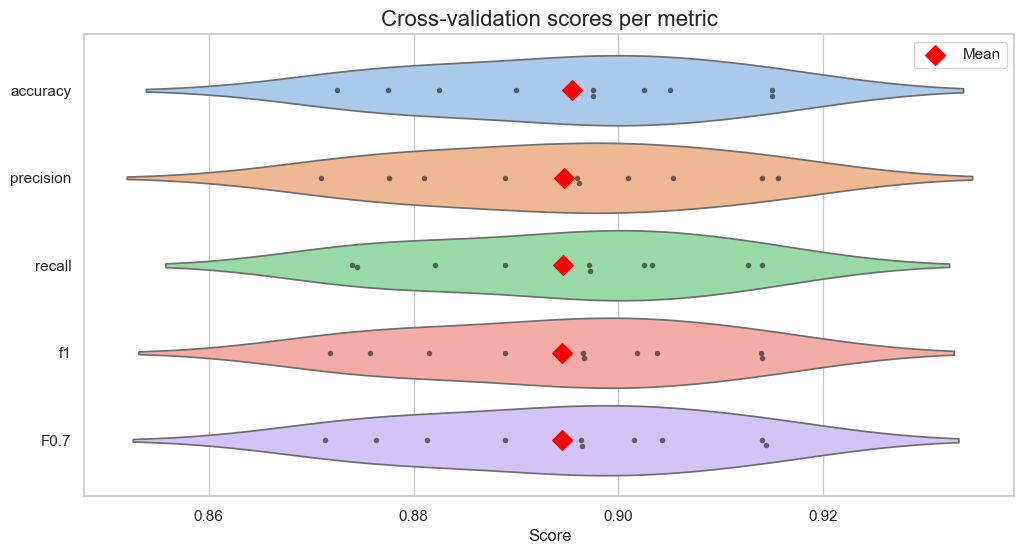

In [42]:
param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['rbf', 'poly', 'sigmoid'],
    'svm__gamma': ['scale', 'auto'],
    'svm__degree': [2, 3],  # Only relevant for 'poly' kernel
    'svm__class_weight': ['balanced']
}

# Pipeline including preprocessor and SVM: 
# Crucial to avoid data leakage during cross-validation
pipe_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svm', SVC())
])

# Cross-validation stratified
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Hyperparameter tuning with GridSearchCV
grid = GridSearchCV(
    pipe_svm, 
    param_grid, 
    cv=cv, 
    scoring=scoring, 
    refit= 'F0.7', # metric to optimize
    n_jobs=-1
)

grid.fit(X_train, y_train)

# Printing best parameters and best score
print("Best params: ", grid.best_params_)   
print("Best score : ", grid.best_score_)

# final SVM linear model with best hyperparameters (already trained)
non_linear_svm_final = grid.best_estimator_

# Cross-validation scores
non_linear_svm_scores = evaluate_all_metrics(grid)
df_results = visualize_cross_val_metrics(non_linear_svm_scores)


# ----- PREDICTION ON TEST SET -----
y_pred_test_svm = non_linear_svm_final.predict(X_test)

# ----- PREDICTION ON TRAIN SET ----- (useful to check overfitting)
y_pred_train_svm = non_linear_svm_final.predict(X_train)

### **Key Decisions in Model Architecture (Non-Linear SVM)**

1. **Kernel Parameter** (**``svm__kernel``**): This is the major upgrade from the previous model. We test rbf (Radial Basis Function), poly (Polynomial), and sigmoid. Unlike linear SVM, these kernels allow the model to draw curved or complex boundaries to separate target classes.

2. **Tuning the Curvature**:

    * **``gamma``**: Controls how big the influence area of a single training point is (how far does the effect of a training point extend on the decision frontier). We test ``scale`` and ``auto`` to see if the model needs a "tighter" fit around data points or a smoother boundary.

    * **``degree``**: Specifically for the poly kernel, to check if there is any quadratic (2) or cubic (3) relationship between features.

### **Metrics and results on test and train set** 
This is our model selection for this problem. Therefore, we are supposing test data is new data to assess how the model would run in real world.

------------------ TEST SET: NON-LINEAR SVM RESULTS ------------------
Accuracy : 0.894
Macro-Precision: 0.893
Macro-Recall   : 0.893
Macro-F1-score : 0.893


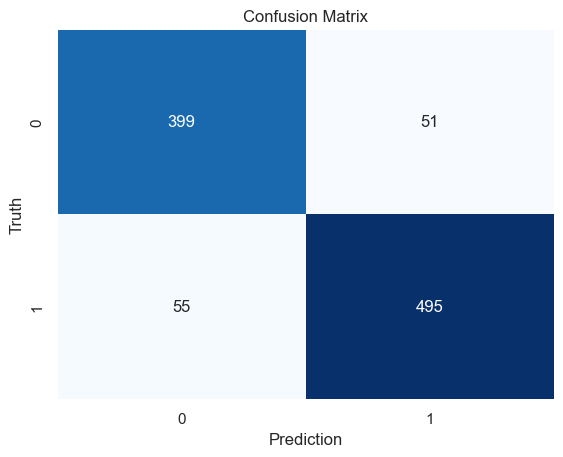


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       450
           1       0.91      0.90      0.90       550

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000


------------------ TRAIN SET: NON-LINEAR SVM RESULTS ------------------
Accuracy : 0.942
Macro-Precision: 0.941
Macro-Recall   : 0.941
Macro-F1-score : 0.941


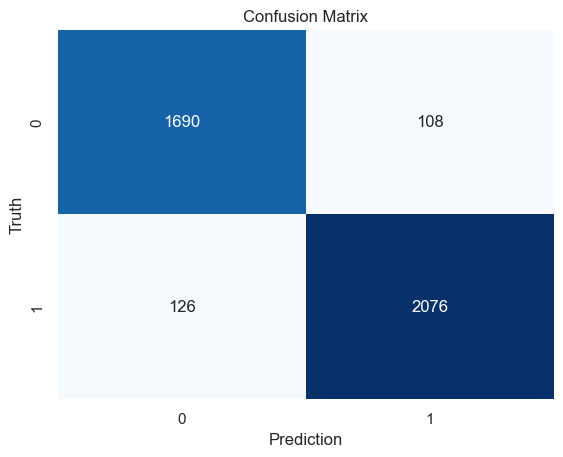


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1798
           1       0.95      0.94      0.95      2202

    accuracy                           0.94      4000
   macro avg       0.94      0.94      0.94      4000
weighted avg       0.94      0.94      0.94      4000




In [43]:
# ----- RESULTS ON TEST SET -----
print(print_metrics(y_test, y_pred_test_svm, "TEST SET: NON-LINEAR SVM"))

# ----- RESULTS ON TRAIN SET -----
print(print_metrics(y_train, y_pred_train_svm, "TRAIN SET: NON-LINEAR SVM"))

### **Model Results Analysis: Non-Linear SVM**

1. **General Performance**:

    * **Highest Accuracy** (0.894): The model achieves ~89% accuracy on the Test Set. This is a clear improvement over the Linear SVM (~86%) and KNN (~86%), proving that the relationship between features and loan defaults is complex and non-linear.

    * **Stable Generalization**: The Train Set accuracy (0.942) is slightly higher than Test (0.894), suggesting kind of overfitting compared to the simpler models. However, the drop is acceptable given the significant gain in predictive power on unseen data.

2. **Risk Assessment**:

    * False Positives: 51 FP. This is the lowest error rate so far (Linear SVM had 60, KNN had 85). This means the model correctly identified and rejected 399 out of 450 bad applicants. By catching these additional potential *defaulters*, the bank saves significant capital.

    * Precision (Class 1): 0.91. Means there is a 91% chance the borrower will pay, once it's loan is approved

3. **Opportunity Cost**:

    * False Negatives: 55 FN. This is lower than the Linear SVM (79 FN).

Conclusion: The Non-Linear SVM reduced the "Bad Loans" (FP) and simultaneously reduced the "Wrongly Rejected" (FN). It found a better decision boundary that separates good and bad payers in a more effectively way.

### Plot of **feature importance** of non-linear SVM best model

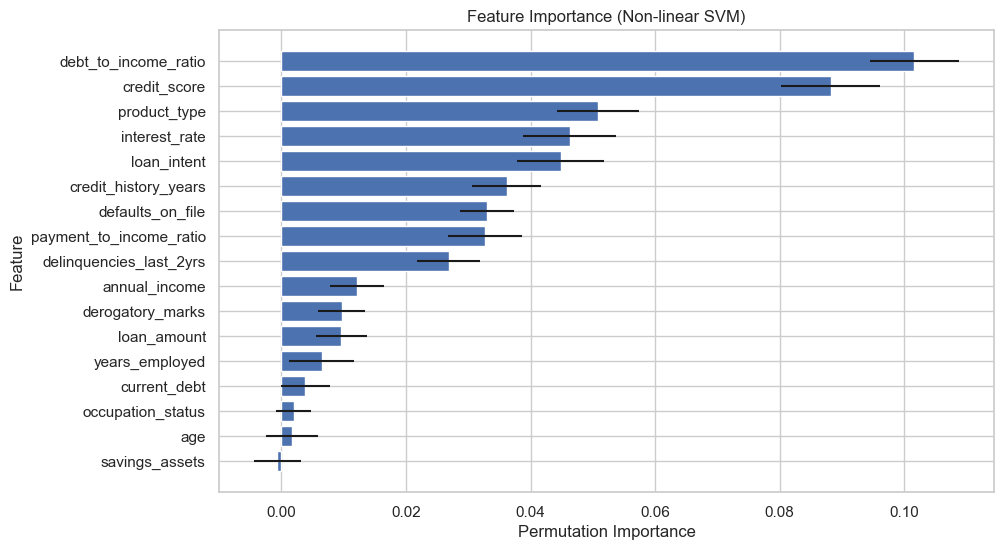

In [44]:
# Permutation importance - A different approach to calculate feature importance
result = permutation_importance(
    non_linear_svm_final,
    X_test,
    y_test,
    n_repeats=30,
    random_state=42,
    scoring='f1'
)

feature_importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std 
}).sort_values(by='importance_mean', ascending=False)  

# Plot results
plt.figure(figsize=(10,6))
plt.barh(
    feature_importance_df['feature'],
    feature_importance_df['importance_mean'], 
    xerr=feature_importance_df['importance_std']
)
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.title("Feature Importance (Non-linear SVM)")
plt.gca().invert_yaxis() 

- The analysis identifies **`Debt-to-Income Ratio`** (~0.10) and **`Credit Score`** as the dominant features for classification.  
  
- Intermediate features related to loan characteristics, such as **`Product Type`** and **`Interest Rate`**, show moderate influence.
  
- Notably, the features at the bottom (e.g., **`Age`**, **`Savings`**) display importance scores near zero with error bars crossing into negative values, indicating they are likely introducing noise rather than predictive signal.

#### **Why permutation importance over SHAP here?**

Since Non-linear SVMs lack inherent feature weights, **Permutation Importance** provides a direct and intuitive metric of how significantly the model's accuracy degrades when a specific feature's information is removed. Moreover, **Kernel SHAP** is computationally expensive for this architecture.

## **Decision Tree Classifier**

Best CV F1 score: 0.846022672721144
Best params     : {'dt__class_weight': 'balanced', 'dt__criterion': 'gini', 'dt__max_depth': 8, 'dt__max_features': None, 'dt__min_samples_leaf': 10, 'dt__min_samples_split': 5}


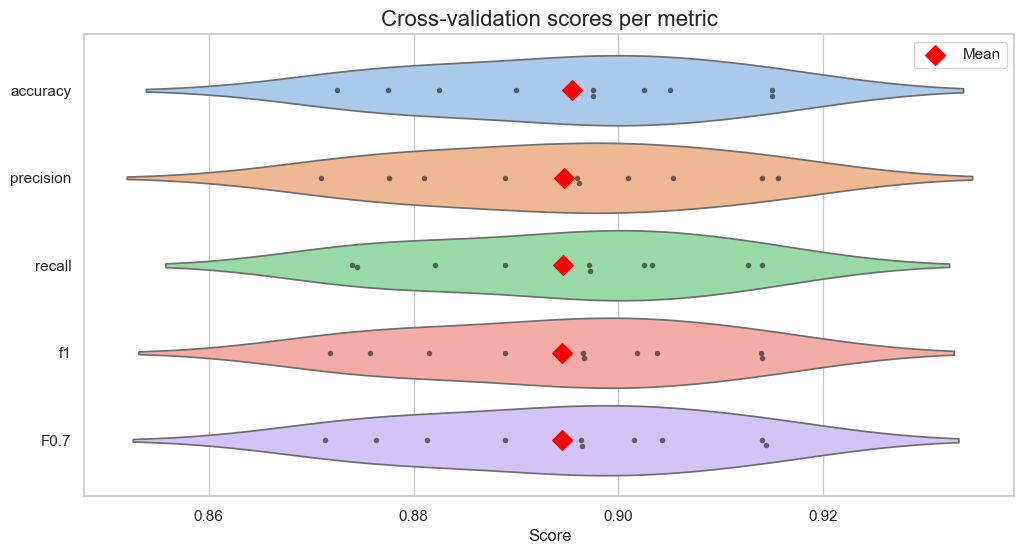

In [45]:
param_grid = {
    "dt__max_depth": [5, 8, 12, 16, None],
    "dt__min_samples_split": [5, 10, 20],
    "dt__min_samples_leaf": [2, 5, 10],
    "dt__max_features": [None, "sqrt", "log2"],
    "dt__criterion": ["gini", "entropy"],
    "dt__class_weight": ['balanced']
}


# Decision Tree 
pipe_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('dt', DecisionTreeClassifier(random_state=42))
])  


# Stratified cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Grid search with cross-validation
grid_search = GridSearchCV(
    pipe_dt,
    param_grid,
    cv=cv,
    scoring=scoring,
    refit= 'F0.7', # metric to optimize
    n_jobs=-1 # Use all available cores
)

grid_search.fit(X_train, y_train) # Fitting with raw data (just ohe)

print("Best CV F1 score:", grid_search.best_score_)
print("Best params     :", grid_search.best_params_)

# Best estimator
dt_final = grid_search.best_estimator_

# Cross-validation scores
dt_scores = evaluate_all_metrics(grid)
visualize_cross_val_metrics(dt_scores)


### **Key Decisions in Model Architecture (Decision Tree)**

1. **Regularization**: The biggest risk with Decision Trees is overfitting, as because of the algorithm design, it tends to memorize the training data perfectly, creating a complex set of rules that will fail on new data. In order to prevent this:

    * ``max_depth: [5, 8, 12, 16, None]``: Limits how deep the tree can grow. For little values, the tree is simpler and more interpretable, whereas None value allows the model to grow it until leaves are pure (risky - overfitting).

    * ``min_samples_split`` & ``min_samples_leaf``: To prevent the model from creating specific rules for single outliers.

2. **Handling Imbalance**

    * ``class_weight='balanced'``: When calculating impurity for a split, an error on a Refusal counts more than an error on a Approval. This forces the tree to create branches specifically to catch those default cases.

3. **Feature Randomness**

    * ``max_features: [None, "sqrt", "log2"]``: Instead of looking at every feature to find the best split at every node, the tree will look at a random subset created out of sqrt(n_samples) or log2(n_samples). Adding randomness avoids the model to be overfitted and likely to get stuck on one dominant feature.

Depth of the tree: 8
Number of terminal nodes: 91


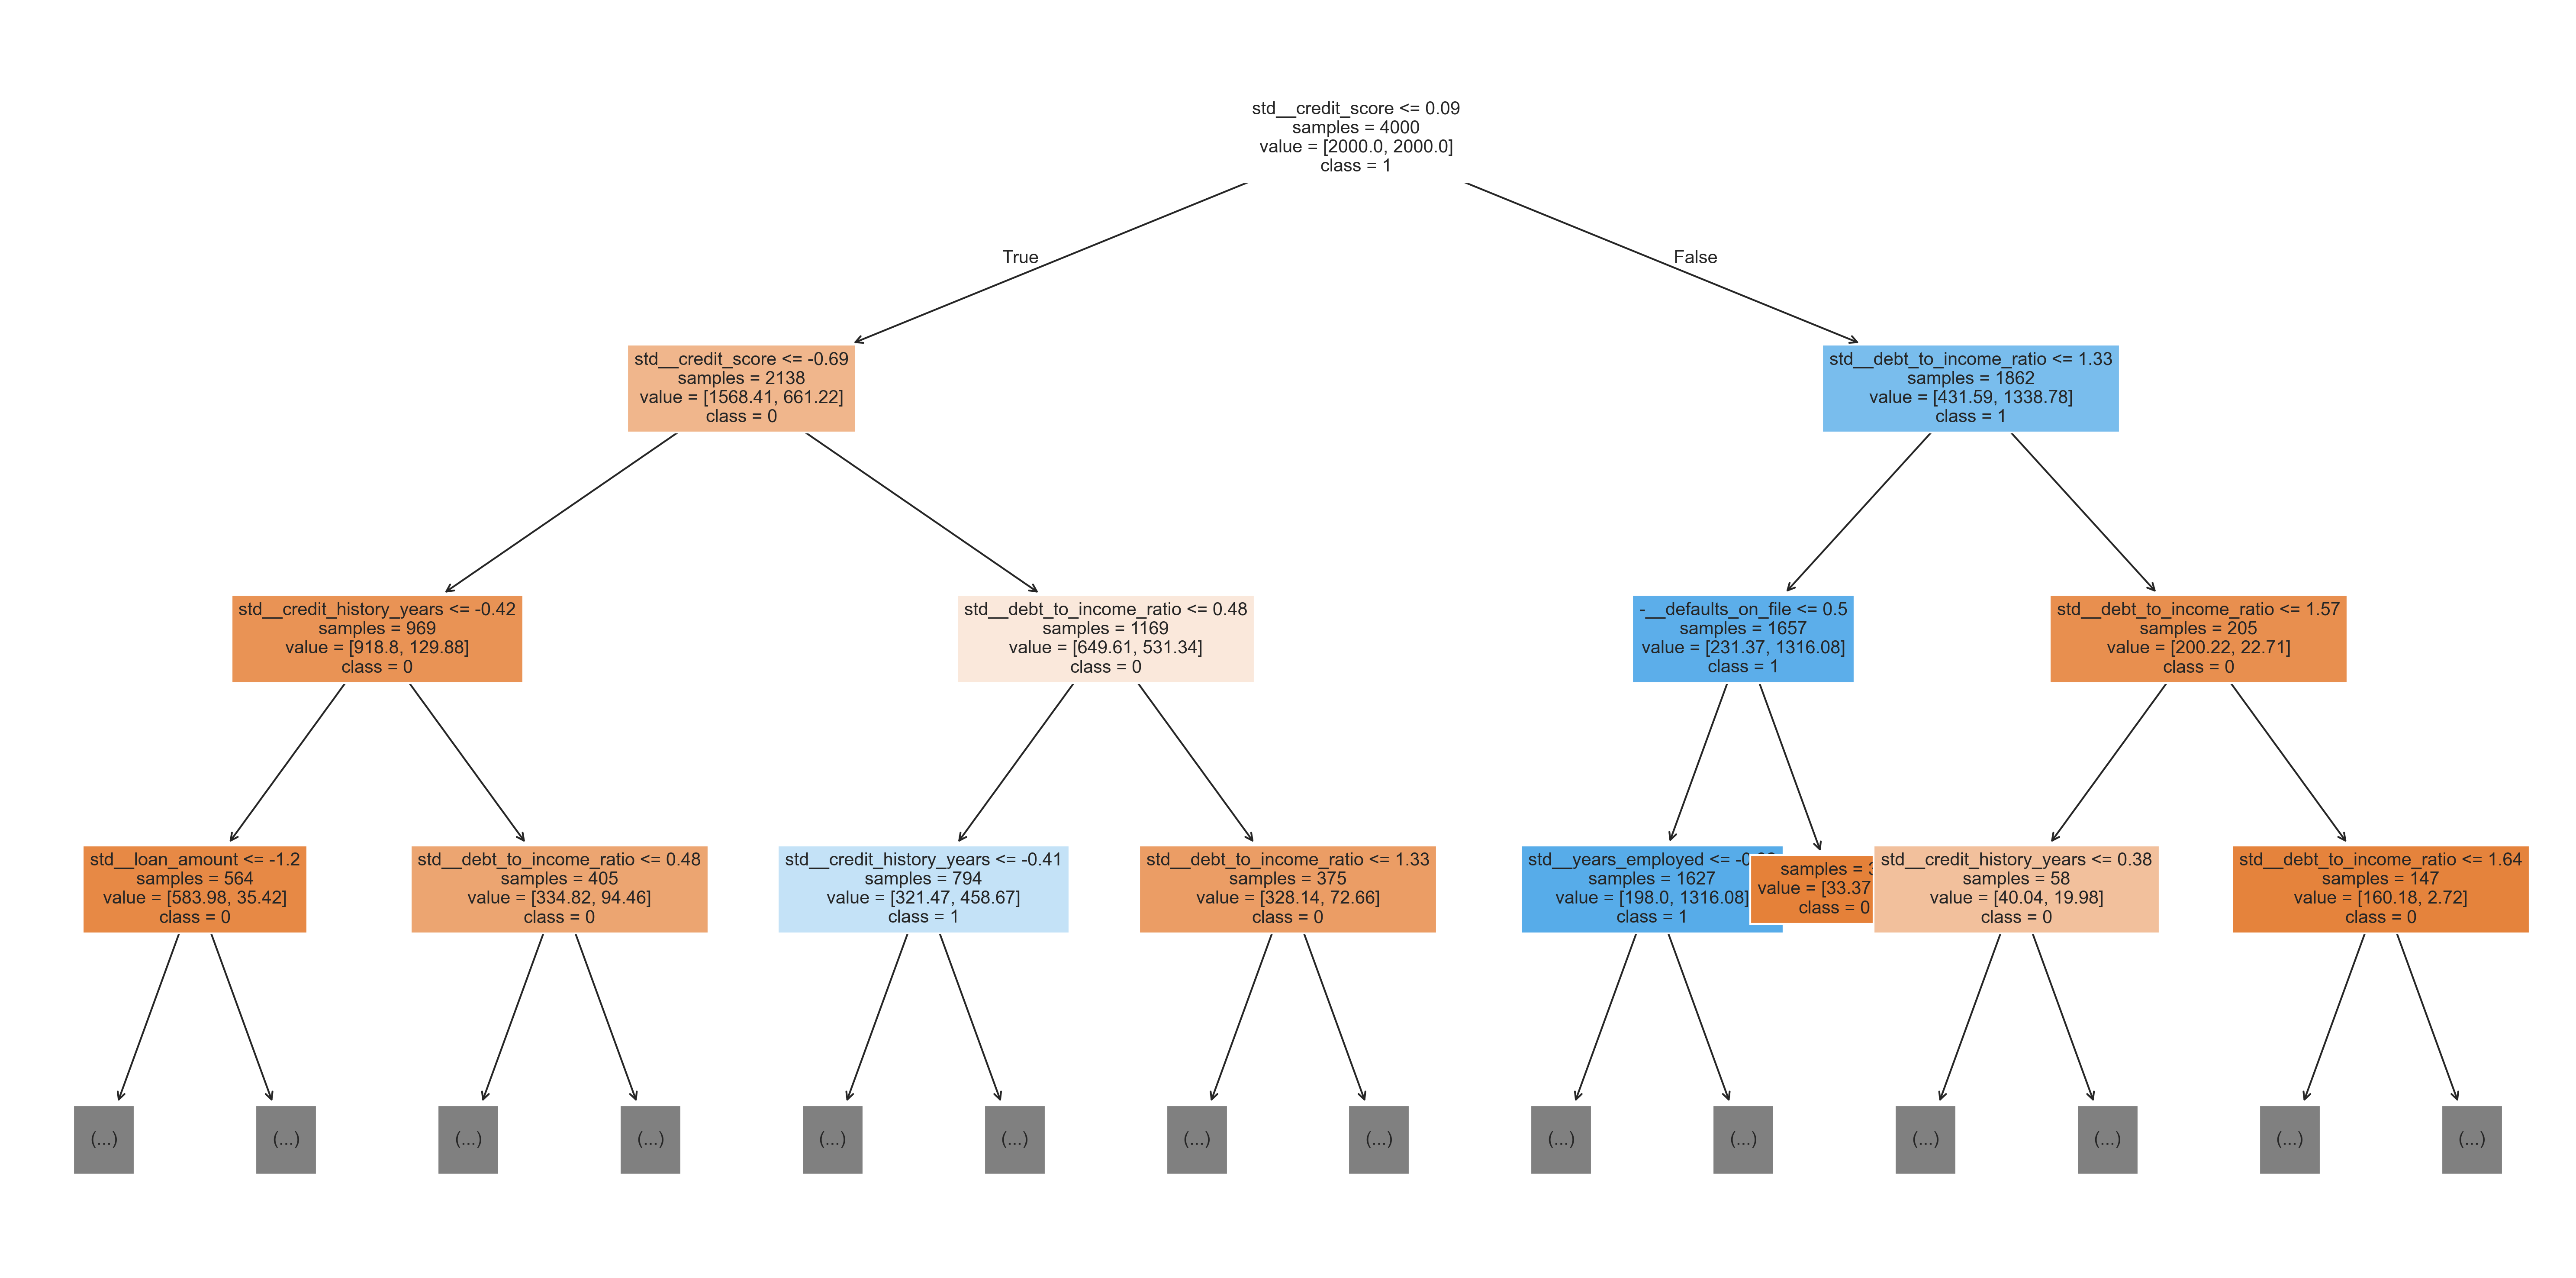

In [46]:
plot_decision_tree(dt_final, fig_size_x=20, fig_size_y=10, max_depth=3)

### **Tree Interpretation**

*Remark: Only 3 depth levels are shown because higher levels generate a diagram wich is not perfectly clear. Adjust ``figsize`` and ``max_depth`` to have a deeper look.*

1. **Root Split**: the most important discriminator.

    * ``credit_score <= 0.09`` (almost the average credit)

        * True → Left Branch: Applicants with average or low credit scores. The box is Orange (High Risk zone).

        * False → Right Branch: Applicants with above-average credit scores. The box is Blue (Safe zone).

2. **Left Side** of the tree: most risky part.
    
    * ``credit_score <= -0.69``. If your credit score is low, the model immediately checks if it is really low.

    * Yes → Left: It checks ``credit_history_years``. If you have bad credit and a short history (<= -0.42), the box turns dark orange. You are almost certainly a default risk.

    * No → Right: It checks ``debt_to_income_ratio``. Even with mediocre credit, if your debt is low (<= 0.48), the model might give you a chance (lighter orange split and then potential blue leaves).

3. **Right Side** of the tree: the safe part.

    * ``debt_to_income_ratio <= 1.33``. Although having a good credit store, the model searches after red flags.

        * True → Left Branch: It immediately checks ``defaults_on_file``. If you have good credit, manageable debt, and no prior defaults (<= 0.5), you land in the Darkest Blue box (Safest Borrowers)

        * False → Right Branch: The next box is orange (risky). This means thah high credit score does not save you if your debt is massive. The model correctly identifies that over-leveraged "good" borrowers are actually high risk.

    **Conclusion**: The Decision Tree offers clear, human-like reasoning: it prioritizes credit score, then looks for either softening factors (for low-score applicants) or disqualifiers (for high-score applicants). Although it is interpretable and mirrors real logic, it performs worse than the SVM models, with slightly higher overfitting and more risky approvals.


## **Logistic Regression**

c:\Users\jlope\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Best params:  {'logreg__C': 10, 'logreg__class_weight': 'balanced', 'logreg__l1_ratio': 0.5, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}
Best score :  0.8607264455289991


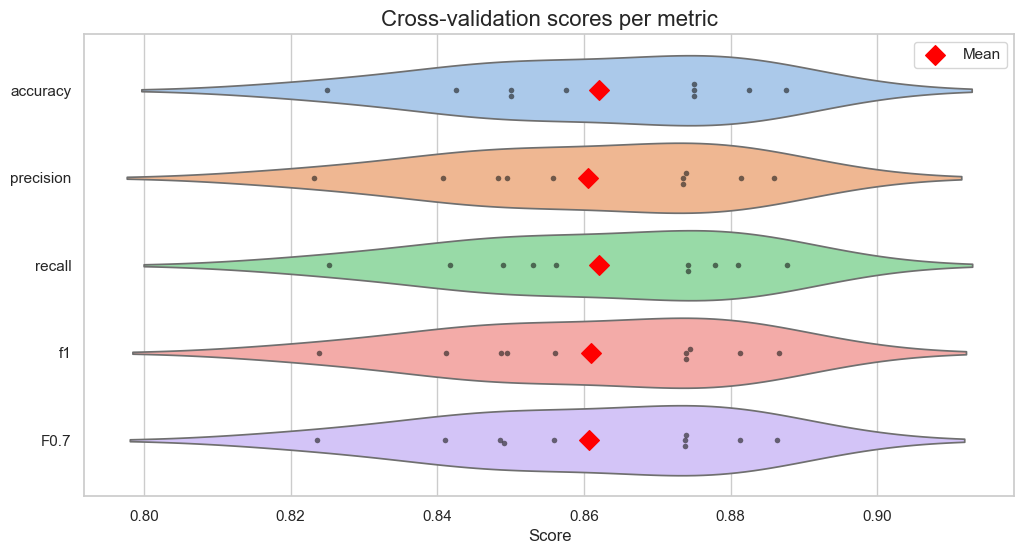

In [47]:
# Grid 
param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10],
    'logreg__penalty': ['l1', 'l2', 'elasticnet'],
    'logreg__solver': ['saga'],
    'logreg__l1_ratio': [0.5],  # only necessary if penalty='elasticnet'
    'logreg__class_weight': ['balanced']
}

pipe_logreg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=5000))
])

# Cross-validation stratified
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Hyperparameter tuning with GridSearchCV
grid = GridSearchCV(
    pipe_logreg, 
    param_grid, 
    cv=cv, 
    scoring=scoring,
    refit='F0.7', 
    n_jobs=-1
)

grid.fit(X_train, y_train)

# Printing best parameters and best score
print("Best params: ", grid.best_params_)
print("Best score : ", grid.best_score_)

# final Logistic Regression model with best hyperparameters (already trained)
logreg_final = grid.best_estimator_

# Extract model from the pipeline
log_reg = logreg_final.named_steps['logreg']

# To plot feature importance
explainer_log = shap.LinearExplainer(log_reg, X_train_transformed_df) # using df instead of matrix to preseve feature names
shap_values_logistic = explainer_log(X_test_transformed_df)

# Cross-validation scores
logreg_scores = evaluate_all_metrics(grid)
visualize_cross_val_metrics(logreg_scores)

### **Key Decisions in Model Architecture (Logistic Regression)**

1. **``logreg__C: [0.01, 0.1, 1, 10]``**: Smaller ``C`` apply strong regularization, forcing the model to keep coefficients small and simple, which prevents overfitting but might miss patterns; while larger ``C`` apply weak regularization, giving the model choice to fit the training data very closely, which captures more detail but risks memorizing noise.

2. **``solver='saga'``**: It is the only solver in Scikit-Learn that supports all penalty types (L1, L2, and ElasticNet).

3. **Flexible Regularization**
    * ``penalty: ['l1', 'l2', 'elasticnet']``:
        * ``L1 (Lasso)``: Can drive coefficients to exactly zero, effectively performing feature selection (discarding useless variables).
        * ``L2 (Ridge)``: Shrinks coefficients to prevent overfitting but keeps all features.
        * ``ElasticNet``: mixes both previous parameters. The ``l1_ratio=[0.5]`` parameter tells the model to mix them 50/50.


### **Feature importance** in Logistic Regression best model

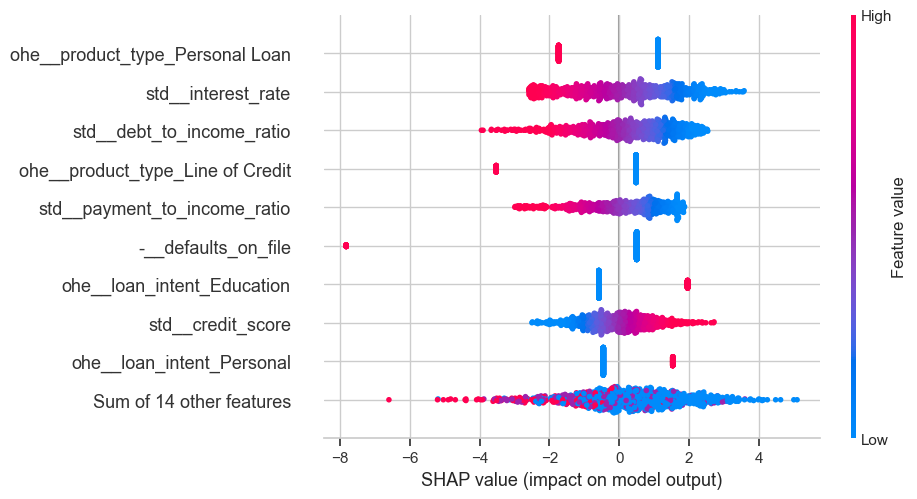

In [48]:
shap.plots.beeswarm(shap_values_logistic)

The impact of each feature in the model optimization appears to be very similar to the linear SVM case. 

- **Push to Reject**:

    * **``product_type_Personal Loan``**: The most impactful feature. Simply requesting this loan type drastically increases rejection probability. Additionally, appliying for ``product_type_Personal Loan`` has also a strong rejection tendency, but the feature's impact is generally softer.

    *The rest of the features act exactly as in Linear SVM*

    * **``interest_rate``**: Higher rates (Red dots) align with higher risk, pushing predictions toward default.

    * **High Debt Ratios** (``debt_to_income``, ``payment_to_income``): As expected, over-leveraged applicants are heavily penalized.

    * **``defaults_on_file``**: clients with defaults on their credit history are enormously penalized.

- **Push to Approve**:

    * **``loan_intent_Education``**: Borrowing for education is a strong indicator of a safe loan.

    * **``credit_score``**: High scores (red dots) consistently push the model toward approval.

**Conclusion**: that two different mathematical approaches (*Probabilistic* with Logistic Regresion vs. *Geometric* with Linear SVM) agree that this set of features influence the same way in both cases, backs up this is a **true pattern** in the *``Loan_approval_data_2025``* dataset, not just a singularity of one specific algorithm.